In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import torch.optim as optim
import torchmetrics

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(23),
        #T.RandomPerspective(),
        T.ToTensor() # автоматически интервал пикселей будет 0-1
    ]
)

In [3]:
train_dataset = torchvision.datasets.ImageFolder(
    './data/archive_sport/train',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    './data/archive_sport/valid',
    transform=T.Compose([T.Resize((224, 224)), T.ToTensor()])
)

In [4]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}

In [5]:
idx2class

{0: 'air hockey',
 1: 'ampute football',
 2: 'archery',
 3: 'arm wrestling',
 4: 'axe throwing',
 5: 'balance beam',
 6: 'barell racing',
 7: 'baseball',
 8: 'basketball',
 9: 'baton twirling',
 10: 'bike polo',
 11: 'billiards',
 12: 'bmx',
 13: 'bobsled',
 14: 'bowling',
 15: 'boxing',
 16: 'bull riding',
 17: 'bungee jumping',
 18: 'canoe slamon',
 19: 'cheerleading',
 20: 'chuckwagon racing',
 21: 'cricket',
 22: 'croquet',
 23: 'curling',
 24: 'disc golf',
 25: 'fencing',
 26: 'field hockey',
 27: 'figure skating men',
 28: 'figure skating pairs',
 29: 'figure skating women',
 30: 'fly fishing',
 31: 'football',
 32: 'formula 1 racing',
 33: 'frisbee',
 34: 'gaga',
 35: 'giant slalom',
 36: 'golf',
 37: 'hammer throw',
 38: 'hang gliding',
 39: 'harness racing',
 40: 'high jump',
 41: 'hockey',
 42: 'horse jumping',
 43: 'horse racing',
 44: 'horseshoe pitching',
 45: 'hurdles',
 46: 'hydroplane racing',
 47: 'ice climbing',
 48: 'ice yachting',
 49: 'jai alai',
 50: 'javelin',
 5

In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [7]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

CUDA доступна!


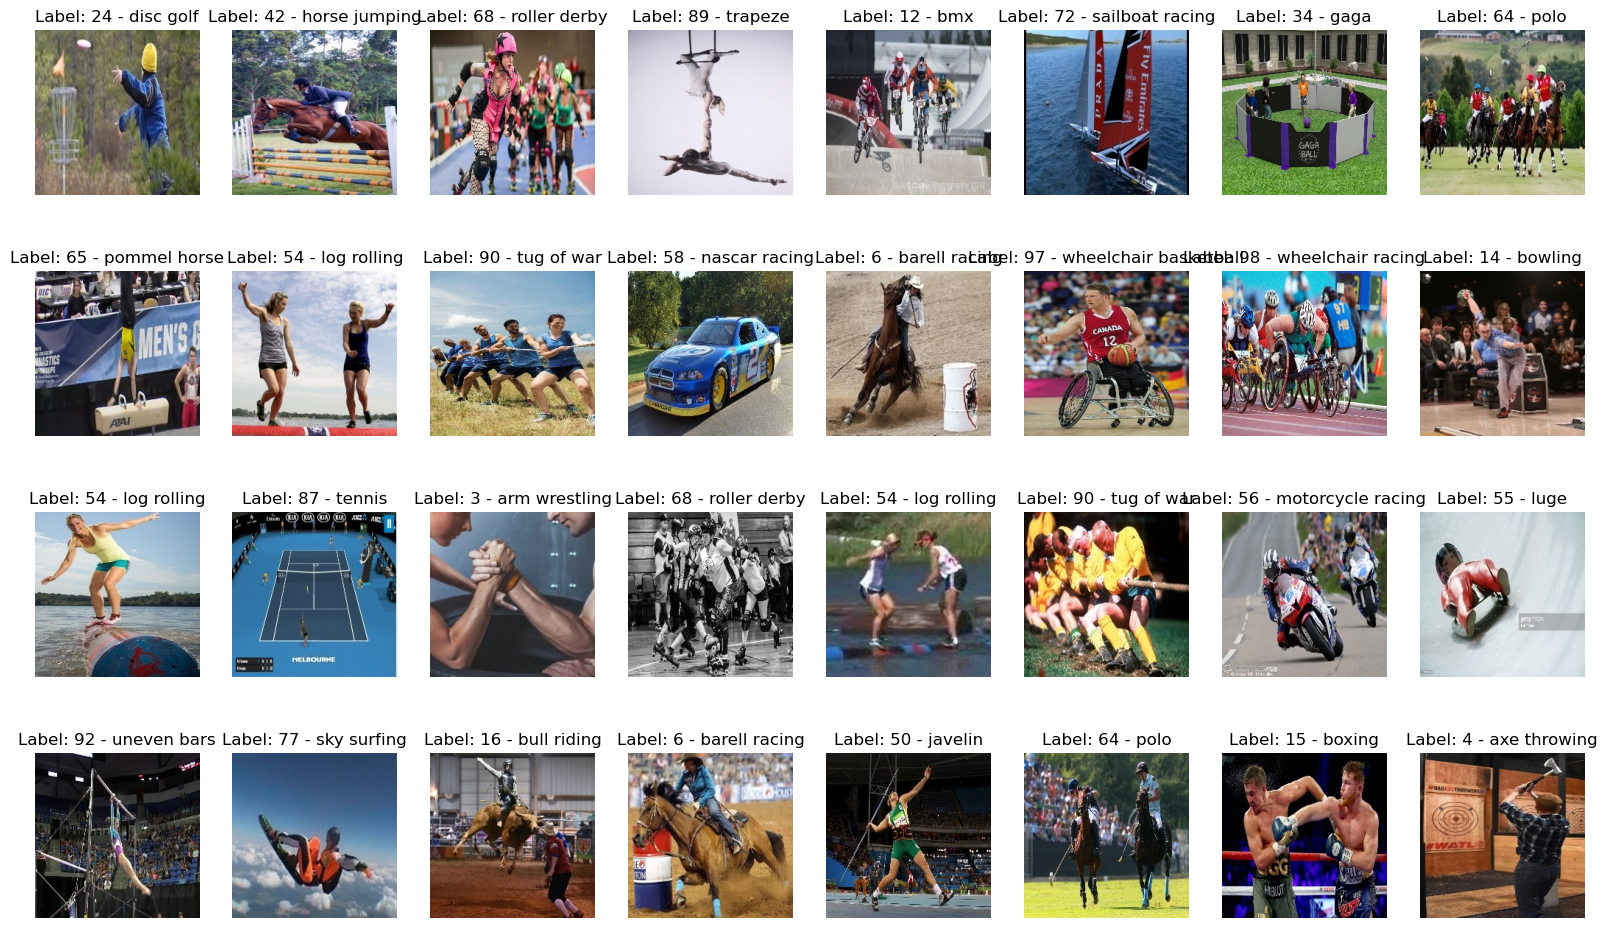

In [8]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch

for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    plot.set_title(f'Label: {label_index} - {valid_loader.dataset.classes[label_index]}')

    # Проверяем количество каналов
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    elif test_samples[i].shape[0] == 1:  # Если 1 канал (оттенки серого)
        img = test_samples[i][0, :, :]  # Оставляем как есть
    else:
        raise ValueError("Неизвестное количество каналов")

    plot.imshow(img.cpu())  # Используем imshow() для цветных изображений
    plot.axis('off')

plt.show()

In [9]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        ) -> tuple[list, ...]:

    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=100).to(device)  # Инициализируем torchmetrics.Accuracy

    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    time_metrics = []

    for epoch in range(n_epochs):
        start = datetime.datetime.now()
        
        model.train()

        train_loss_epoch = []
        train_metric_epoch = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)  # Используем переданный criterion

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)  # Используем torchmetrics.Accuracy
            train_loss_epoch.append(loss.item())
            train_metric_epoch.append(acc.item())

        model.eval()

        valid_loss_epoch = []
        valid_metric_epoch = []

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)  # Получаем выходы модели

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            valid_loss_epoch.append(loss.item())
            valid_metric_epoch.append(acc.item())

        epoch_train_loss = np.mean(train_loss_epoch)
        epoch_train_metric = np.mean(train_metric_epoch)

        epoch_valid_loss = np.mean(valid_loss_epoch)
        epoch_valid_metric = np.mean(valid_metric_epoch)

        time = (datetime.datetime.now() - start).total_seconds()
        time_metrics.append(round(time))
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_metrics.append(epoch_train_metric)
        valid_metrics.append(epoch_valid_metric)
        

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_metric:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_metric:.4f}")

        
    return train_losses, valid_losses, train_metrics, valid_metrics, time_metrics

In [10]:
from torchvision.models import resnet18, ResNet18_Weights

model_lrs = resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
tu.get_model_summary(model_lrs.to(device), test_samples[1].unsqueeze(0).to(device))

Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [1, 64, 112, 112]       9,408   118,013,952
1_bn1                                              [64]   [1, 64, 112, 112]         128     3,211,264
2_relu                                                -   [1, 64, 112, 112]           0             0
3_maxpool                                             -     [1, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
5_layer1.0.BatchNorm2d_bn1                         [64]     [1, 64, 56, 56]         128       802,816
6_layer1.0.ReLU_relu                                  -     [1, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [1, 64, 56, 56]      36,864   115,605,504
8_layer1.0.BatchNorm2d_bn2                         [64]     [1, 64, 56, 56]       

In [12]:
display(model_lrs.fc)
model_lrs.fc = nn.Linear(512, 100)
display(model_lrs.fc)

Linear(in_features=512, out_features=1000, bias=True)

Linear(in_features=512, out_features=100, bias=True)

In [13]:
for param in model_lrs.parameters():
    param.requires_grad = False

In [14]:
for i, param in enumerate(model_lrs.parameters()):
    print(i, param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False


In [15]:
model_lrs.fc.weight.requires_grad = True
model_lrs.fc.bias.requires_grad = True

model_lrs.layer4[0].conv2.weight.requires_grad = True
model_lrs.layer4[0].bn2.weight.requires_grad = True
model_lrs.layer4[0].bn2.bias.requires_grad = True

model_lrs.layer4[0].downsample[0].weight.requires_grad = True
model_lrs.layer4[0].downsample[1].weight.requires_grad = True
model_lrs.layer4[0].downsample[1].bias.requires_grad = True

model_lrs.layer4[1].conv1.weight.requires_grad = True
model_lrs.layer4[1].bn1.weight.requires_grad = True
model_lrs.layer4[1].bn1.bias.requires_grad = True

model_lrs.layer4[1].conv2.weight.requires_grad = True
model_lrs.layer4[1].bn2.weight.requires_grad = True
model_lrs.layer4[1].bn2.bias.requires_grad = True

In [16]:
for param in model_lrs.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [17]:
criterion_lrs = nn.CrossEntropyLoss()
optimizer_lrs = optim.Adam(model_lrs.parameters(), lr=0.0005)

In [18]:
model_lrs.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
history = None

In [ ]:
%%time
start = datetime.datetime.now()
print('Время старта: ' + str(start))

model_lrs.to(device)

model_data = fit(n_epochs=30, model=model_lrs, optimizer=optimizer_lrs, train_loader=train_loader, valid_loader=valid_loader, criterion=criterion_lrs)

finish = datetime.datetime.now()
print('Время окончания: ' + str(finish))

# вычитаем время старта из времени окончания
print('Время : ' + str(finish - start))

Время старта: 2025-02-07 11:34:41.058362
Epoch 1/30: Train Loss: 2.4190, Train Accuracy: 0.4789, Valid Loss: 0.9130, Valid Accuracy: 0.8058
Epoch 2/30: Train Loss: 0.9893, Train Accuracy: 0.7710, Valid Loss: 0.5317, Valid Accuracy: 0.8664
Epoch 3/30: Train Loss: 0.6613, Train Accuracy: 0.8381, Valid Loss: 0.4159, Valid Accuracy: 0.8977
Epoch 4/30: Train Loss: 0.5067, Train Accuracy: 0.8740, Valid Loss: 0.3847, Valid Accuracy: 0.8977
Epoch 5/30: Train Loss: 0.3962, Train Accuracy: 0.8993, Valid Loss: 0.3317, Valid Accuracy: 0.9038
Epoch 6/30: Train Loss: 0.3262, Train Accuracy: 0.9172, Valid Loss: 0.3131, Valid Accuracy: 0.9178
Epoch 7/30: Train Loss: 0.2896, Train Accuracy: 0.9259, Valid Loss: 0.2684, Valid Accuracy: 0.9239
Epoch 8/30: Train Loss: 0.2356, Train Accuracy: 0.9426, Valid Loss: 0.2729, Valid Accuracy: 0.9167
Epoch 9/30: Train Loss: 0.2076, Train Accuracy: 0.9479, Valid Loss: 0.2772, Valid Accuracy: 0.9220
Epoch 10/30: Train Loss: 0.1748, Train Accuracy: 0.9567, Valid Loss:

In [ ]:
#torch.save(model_lrs, './models/model_sport/model.pth')

In [ ]:
#torch.save(model_lrs.state_dict(), './models/model_sport/model_weights.pth')

In [ ]:
train_losses, valid_losses, train_metric, valid_metric, time = model_data

In [ ]:
data_metrics = np.array([
    train_losses, valid_losses, train_metric, valid_metric, time
])

df = pd.DataFrame(data_metrics.T, columns=['train_losses', 'valid_losses', 'train_metric', 'valid_metric', 'time'])
df

In [ ]:
#df.to_csv('./models/model_sport/data.csv', index=False, encoding='utf-8')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(train_losses, label='Train loss')
ax[0].plot(valid_losses, label='Valid Loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_ylim((0, max(train_losses+valid_losses)+.1))

ax[1].plot(train_metric, label='Train accuracy')
ax[1].plot(valid_metric, label='Valid accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_ylim((0, max(train_metric+valid_metric)+.1))

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten() # переводим в одномерный массив
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()  # Получаем индекс метки из тестового набора
    y_pred = torch.argmax(model_lrs(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'g'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:  # Если 3 канала (RGB)
        img = test_samples[i].permute(1, 2, 0)  # Транспонируем в (высота, ширина, каналы)
        #img = (img + 1) / 2  # Переводим в диапазон [0, 1]
        #img = img * 255      # Переводим в диапазон [0, 255]
        #img = img.int()   
    plot.imshow(img.cpu())#plot.matshow(test_samples[i][0, :, :].cpu().detach().numpy(), cmap='gray')
    plot.axis('off')